In [9]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
train_metadata = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_metadata = torchvision.datasets.MNIST(root='./data', train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 128
NUM_TRAIN = 50000
NUM_VAL = 10000

train_x = train_metadata.data[:50000].unsqueeze(1) / 255
val_x = train_metadata.data[-10000:].unsqueeze(1) / 255
test_x = test_metadata.data.unsqueeze(1) / 255
train_y = train_metadata.targets[:50000]
val_y = train_metadata.targets[-10000:]
test_y = test_metadata.targets

# train_x = train_x.reshape(-1,784)
# val_x = val_x.reshape(-1,784)
# test_x = test_x.reshape(-1,784)

train_data = TensorDataset(train_x, train_y)
val_data = TensorDataset(val_x, val_y)
test_data = TensorDataset(test_x, test_y)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
          nn.Conv2d(input_dim, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),

          nn.Flatten(),

          # nn.Linear(128 * 4 * 4, hidden_dim),
          # nn.ReLU(inplace=True),
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        encoded = self.encode(x)
        mu = self.fc_mu(encoded)
        log_var = self.fc_var(encoded)
        z = self.reparameterization(mu, log_var)
        return z, mu, log_var

    def reparameterization(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.rand_like(std).to(DEVICE)
        z = mu + std * epsilon
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=(4, 4), stride=(1, 1), padding=(0, 0)),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, output_dim, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(-1).unsqueeze(-1)
        preds = self.decode(x)
        preds = preds[:, :, 1:29, 1:29]
        return preds


class VAE(nn.Module):
    def __init__(self, encoder, decoder, var=0.5):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.var = var

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_r = self.decoder(z)
        return x_r, mu, log_var

In [5]:
num_channels = train_x.shape[1]
latent_dim = 16
hidden_dim = 128
bernulli_dim = 28 * 28
encoder = Encoder(input_dim=num_channels, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, output_dim=num_channels)
vae = VAE(encoder, decoder).to(DEVICE)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc_mu): Linear(in_features=2048, out_features=16, bias=True)
    (fc_var): Linear(in_features=2048, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): ConvTranspose2d(16, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

def train_vae(num_epochs, dist= 'bernulli'):
    for epoch in tqdm(range(num_epochs)):
        train_elbos = 0.0
        val_elbos = 0.0
        for batch in train_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            x_recon, mu, log_var = vae(x)

            if 'gauss':
              distances = F.mse_loss(x, x_recon, reduction='none')
              log_p = -0.5 * torch.sum(np.log(vae.var * 2 * np.pi) + distances / vae.var)
              kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
              negative_elbo = -log_p + kl

            if 'bernulli':
              bce = F.binary_cross_entropy(x_recon.reshape(-1, 784), x.view(-1, 784), reduction='sum')
              kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
              negative_elbo = bce + kl
              
            negative_elbo.backward()
            optimizer.step()
            train_elbos += negative_elbo.item()

        for batch in val_dataloader:
            x, _ = batch
            x = x.to(DEVICE)
            with torch.no_grad():
                x_recon, mu, log_var = vae(x)

                if 'gauss':
                  distances = F.mse_loss(x, x_recon, reduction='none')
                  log_p = -0.5 * torch.sum(np.log(vae.var * 2 * np.pi) + distances / vae.var)
                  kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                  negative_elbo = -log_p + kl

                if 'bernulli':
                  bce = F.binary_cross_entropy(x_recon.reshape(-1, 784), x.view(-1, 784), reduction='sum')
                  kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
                  negative_elbo = bce + kl

                val_elbos += negative_elbo.item()
        print('Epoch {}, Mean Training ELBO {}, Mean Validation ELBO {}'.format(epoch + 1, train_elbos / NUM_TRAIN, val_elbos / NUM_VAL))
train_vae(num_epochs=20, dist = 'bernulli')

  5%|▌         | 1/20 [00:04<01:32,  4.85s/it]

Epoch 1, Mean Training ELBO 239.43771890625, Mean Validation ELBO 209.05185219726562


 10%|█         | 2/20 [00:09<01:25,  4.75s/it]

Epoch 2, Mean Training ELBO 208.20798046875, Mean Validation ELBO 202.18161735839843


 15%|█▌        | 3/20 [00:13<01:19,  4.69s/it]

Epoch 3, Mean Training ELBO 203.22129427734376, Mean Validation ELBO 200.1471001953125


 20%|██        | 4/20 [00:18<01:14,  4.65s/it]

Epoch 4, Mean Training ELBO 200.610008984375, Mean Validation ELBO 198.09235087890625


 25%|██▌       | 5/20 [00:23<01:09,  4.62s/it]

Epoch 5, Mean Training ELBO 199.07238658203124, Mean Validation ELBO 197.06792373046875


 30%|███       | 6/20 [00:27<01:04,  4.61s/it]

Epoch 6, Mean Training ELBO 197.504331328125, Mean Validation ELBO 194.83402036132813


 35%|███▌      | 7/20 [00:32<00:59,  4.61s/it]

Epoch 7, Mean Training ELBO 194.32806833984375, Mean Validation ELBO 190.40898603515626


 40%|████      | 8/20 [00:36<00:55,  4.61s/it]

Epoch 8, Mean Training ELBO 188.539556640625, Mean Validation ELBO 184.62018771972657


 45%|████▌     | 9/20 [00:41<00:50,  4.62s/it]

Epoch 9, Mean Training ELBO 184.6157144921875, Mean Validation ELBO 184.95268171386718


 50%|█████     | 10/20 [00:46<00:46,  4.64s/it]

Epoch 10, Mean Training ELBO 182.22119994140624, Mean Validation ELBO 177.4534954345703


 55%|█████▌    | 11/20 [00:50<00:41,  4.65s/it]

Epoch 11, Mean Training ELBO 179.7046615625, Mean Validation ELBO 178.1878224609375


 60%|██████    | 12/20 [00:55<00:37,  4.67s/it]

Epoch 12, Mean Training ELBO 177.142919296875, Mean Validation ELBO 174.96967587890626


 65%|██████▌   | 13/20 [01:00<00:32,  4.68s/it]

Epoch 13, Mean Training ELBO 174.94790359375, Mean Validation ELBO 172.9241983154297


 70%|███████   | 14/20 [01:04<00:28,  4.69s/it]

Epoch 14, Mean Training ELBO 172.85726025390625, Mean Validation ELBO 170.49100798339845


 75%|███████▌  | 15/20 [01:09<00:23,  4.69s/it]

Epoch 15, Mean Training ELBO 170.08188677734375, Mean Validation ELBO 166.7181364013672


 80%|████████  | 16/20 [01:14<00:18,  4.68s/it]

Epoch 16, Mean Training ELBO 168.0035053125, Mean Validation ELBO 166.72787775878905


 85%|████████▌ | 17/20 [01:18<00:14,  4.67s/it]

Epoch 17, Mean Training ELBO 166.59980833984375, Mean Validation ELBO 166.78817985839845


 90%|█████████ | 18/20 [01:23<00:09,  4.65s/it]

Epoch 18, Mean Training ELBO 165.41589515625, Mean Validation ELBO 165.38467607421876


 95%|█████████▌| 19/20 [01:28<00:04,  4.64s/it]

Epoch 19, Mean Training ELBO 163.872151953125, Mean Validation ELBO 163.6471721923828


100%|██████████| 20/20 [01:32<00:00,  4.64s/it]

Epoch 20, Mean Training ELBO 163.5249915234375, Mean Validation ELBO 161.69937294921874


In [7]:
def test_vae():
    x, _ = next(iter(test_dataloader))
    x = x.to(DEVICE)
    x_recons = []
    with torch.no_grad():
        x_recon, _, _ = vae(x)
        x_recons.append(x_recon)
    return [x], x_recons
test_batch, test_batch_r = test_vae()

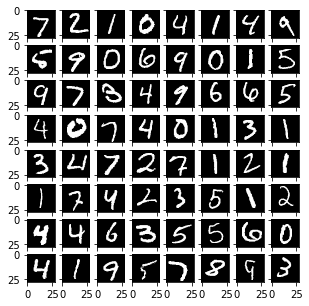

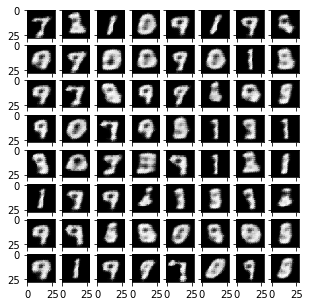

In [10]:
def show_images(x, ncols=64):
    """ plots first ncols images in a batch """
    x = x.view(BATCH_SIZE, 28, 28)
    img_arr = []
    for image in x:
      img_arr.append(image)
    fig = plt.figure(figsize=(5., 5.))
    grid = ImageGrid(fig, 111, 
                 nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

    for ax, im in zip(grid, img_arr):
        
        ax.imshow(im.cpu().numpy(), cmap="Greys_r")
        
show_images(test_batch[0])
show_images(test_batch_r[0])